In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 用线性Autoencoder实现PCA

In [3]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

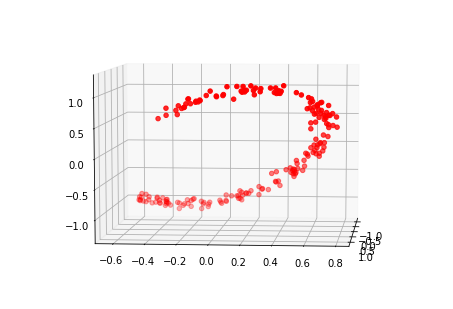

In [17]:
fig = plt.figure()
ax = Axes3D(fig) 
ax.view_init(elev=7., azim=5)
ax.scatter(data[:, 0], data[:, 1], data[:, 0], c='r')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [7]:
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [9]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteraton in range(n_iterations):
        sess.run(training_op, feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

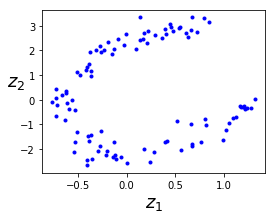

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

In [12]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255.
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [13]:
def shuffle_batch(X, y, batch_size):
    idx = np.random.permutation(len(X))
    n_batches = len(X) / batch_size
    for batch_idx in np.array_split(idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [5]:
def shuffle_batch(X, batch_size):
    idx = np.random.permutation(len(X))
    n_batches = len(X) / batch_size
    for batch_idx in np.array_split(idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch

# Deep Autoencoder

In [27]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

he_init = tf.contrib.layers.variance_scaling_initializer()

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

hidden1 = tf.layers.dense(X, n_hidden1, 
                          activation=tf.nn.elu, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)
hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                          activation=tf.nn.elu, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)
hidden3 = tf.layers.dense(hidden2, n_hidden3, 
                          activation=tf.nn.elu, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)
outputs = tf.layers.dense(hidden3, n_outputs, 
                          kernel_initializer=he_init,
                          kernel_regularizer=l2_regularizer)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_loss)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch in shuffle_batch(X_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Training mse:", loss_train)
        saver.save(sess, "./model/autoencoder.ckpt")

0 Training mse: 0.023810685
1 Training mse: 0.013262189
2 Training mse: 0.0111905765
3 Training mse: 0.010266581
4 Training mse: 0.010843426


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


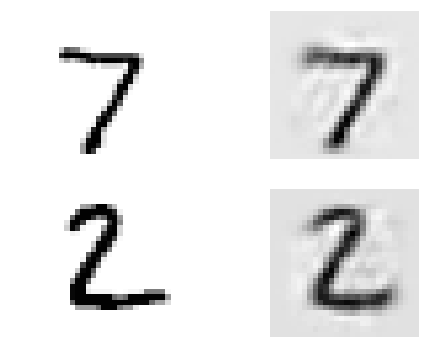

In [14]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# Tying weights

In [19]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [20]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch in shuffle_batch(X_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Training mse:", loss_train)
        saver.save(sess, "./model/autoencoder.ckpt")

0 Training mse: 0.014976371
1 Training mse: 0.01633146
2 Training mse: 0.017098986
3 Training mse: 0.016191907
4 Training mse: 0.017081067


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


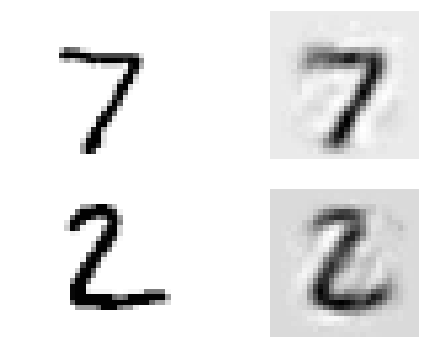

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 在多个图中分开训练一个Autoencoder

In [24]:
reset_graph()

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])

        hidden = tf.layers.dense(X, n_neurons, 
                                 activation=hidden_activation,
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg),
                                 name="hidden")
        outputs = tf.layers.dense(hidden, n_inputs, 
                                  activation=output_activation, 
                                  kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg),
                                  name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch in shuffle_batch(X_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print(epoch, "Training MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [25]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(X_train=X_train, 
                                                  n_neurons=300, 
                                                  n_epochs=4, 
                                                  batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(X_train=hidden_output, 
                                      n_neurons=150, 
                                      n_epochs=4, 
                                      batch_size=150)

0 Training MSE: 0.018673144
1 Training MSE: 0.019126505
2 Training MSE: 0.019383658
3 Training MSE: 0.018060237
0 Training MSE: 0.0045647575
1 Training MSE: 0.0043105115
2 Training MSE: 0.0045071193
3 Training MSE: 0.0044832327


In [26]:
reset_graph()

n_inputs = 28 * 28
X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

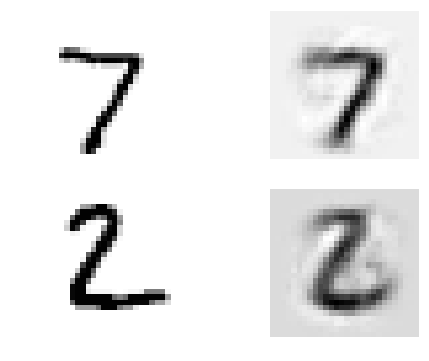

In [27]:
with tf.Session() as sess:
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 在一个图中分开训练一个Autoencoder

In [7]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)

In [8]:
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=[train_vars])

In [9]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase {}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            for X_batch in shuffle_batch(X_train, batch_sizes[phase]):
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_train})
            print(epoch, "Training mse:", loss_train)
            saver.save(sess, "./model/autoencoder.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("Test mse:", loss_test)

Training phase 1
0 Training mse: 0.018840361
1 Training mse: 0.018991342
2 Training mse: 0.019227881
3 Training mse: 0.01949263
Training phase 2
0 Training mse: 0.0039787167
1 Training mse: 0.0038523325
2 Training mse: 0.00392503
3 Training mse: 0.004012286
Test mse: 0.023164956


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


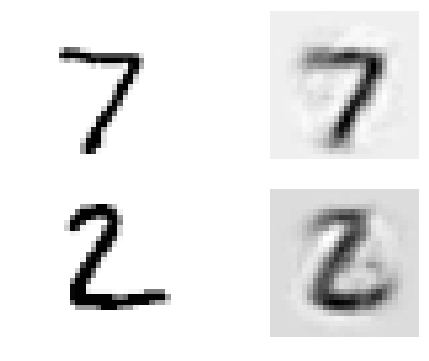

In [43]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 缓存冻结层输出

In [46]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase {}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: X_train})
        for epoch in range(n_epochs[phase]):
            if phase == 1:
                for X_batch in shuffle_batch(hidden1_cache, batch_size):
                    feed_dict = {hidden1: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            else:
                for X_batch in shuffle_batch(X_train, batch_size):
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print(epoch, "Training mse:", loss_train)
            saver.save(sess, "./model/autoencoder.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("Test mse:", loss_test)

Training phase 1
0 Training mse: 0.019054843
1 Training mse: 0.01926956
2 Training mse: 0.018565038
3 Training mse: 0.018962618
Training phase 2
0 Training mse: 0.0040466143
1 Training mse: 0.0038203613
2 Training mse: 0.0040882947
3 Training mse: 0.0039782245
Test mse: 0.022951353


INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


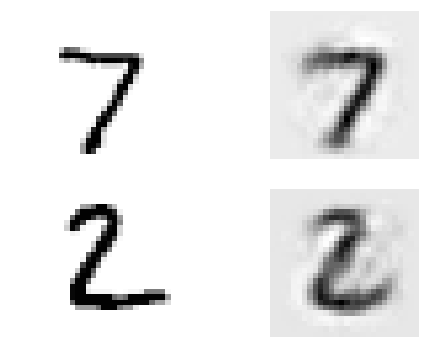

In [47]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    X_test_2 = X_test[:2]
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# 重建可视化

In [9]:
X_test_2 = X_test[:2]

saver = tf.train.import_meta_graph("./model/autoencoder.ckpt.meta")

with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test_2})

fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")   

INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


NameError: name 'outputs' is not defined

# 特征可视化

INFO:tensorflow:Restoring parameters from ./model/autoencoder.ckpt


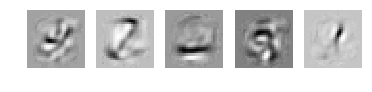

In [14]:
with tf.Session() as sess:
    saver.restore(sess, "./model/autoencoder.ckpt")
    weights1_val = weights1.eval()
    
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(weights1_val.T[i].reshape((28, 28)), 
               cmap="Greys", 
               interpolation="nearest")
    plt.axis("off")

# 无监督的预训练

In [14]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.int32, shape=(None))

weights1_init = initializer((n_inputs, n_hidden1))
weights2_init = initializer((n_hidden1, n_hidden2))
weights3_init = initializer((n_hidden2, n_outputs))

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = tf.nn.elu(tf.matmul(X, weights1) + biases1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [19]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Training acc:", accuracy_val)
        saver.save(sess, "./model/pretrain.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Test acc:", accuracy_val)

0 Training acc: 0.96666664
Test acc: 0.9424
1 Training acc: 0.98
Test acc: 0.9403
2 Training acc: 0.96
Test acc: 0.9534
3 Training acc: 0.96
Test acc: 0.9499


# 去噪自动编码器

In [6]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [7]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, 
                          activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                          activation=tf.nn.relu,
                          name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, 
                          activation=tf.nn.relu,
                          name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, 
                          name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Training mse:", loss_train)
        saver.save(sess, "./model/denoising_autoencoder.ckpt")

0 Training mse: 0.044105534
1 Training mse: 0.044067185
2 Training mse: 0.042517554
3 Training mse: 0.04034232
4 Training mse: 0.042040493
5 Training mse: 0.0400025
6 Training mse: 0.040355623
7 Training mse: 0.041209076
8 Training mse: 0.040748384
9 Training mse: 0.03961383


INFO:tensorflow:Restoring parameters from ./model/denoising_autoencoder.ckpt


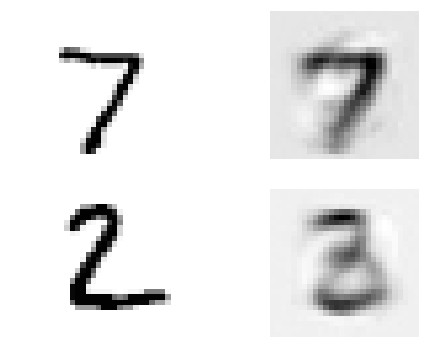

In [10]:
X_test_2 = X_test[:2]

with tf.Session() as sess:
    saver.restore(sess, "./model/denoising_autoencoder.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [11]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [12]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name="training")

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, 
                          activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                          activation=tf.nn.relu,
                          name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, 
                          activation=tf.nn.relu,
                          name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, 
                          name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Training mse:", loss_train)
        saver.save(sess, "./model/denoising_autoencoder.ckpt")

0 Training mse: 0.03065737
1 Training mse: 0.028450713
2 Training mse: 0.02721322
3 Training mse: 0.02329303
4 Training mse: 0.024617389
5 Training mse: 0.023942469
6 Training mse: 0.024188211
7 Training mse: 0.024774041
8 Training mse: 0.023756387
9 Training mse: 0.022962809


INFO:tensorflow:Restoring parameters from ./model/denoising_autoencoder.ckpt


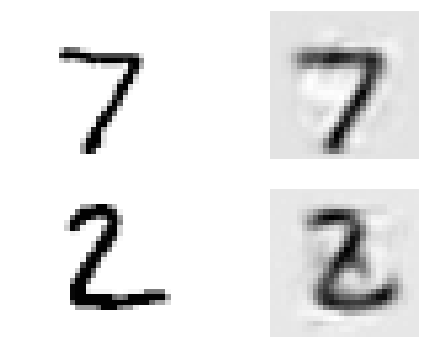

In [14]:
X_test_2 = X_test[:2]

with tf.Session() as sess:
    saver.restore(sess, "./model/denoising_autoencoder.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# Sparse Autoencoder

In [17]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000
n_outputs = n_inputs

In [18]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, 
                                                                         sparsity_loss, 
                                                                         loss],
                                                                        feed_dict={X: X_batch})
        print(epoch, "Training mse:", reconstruction_loss_val,
              "Sparsity loss:", sparsity_loss_val,
              "Total loss:", loss_val)
        saver.save(sess, "./model/sparse.ckpt")

0 Training mse: 0.08536965 Sparsity loss: 0.379071 Total loss: 0.16118385
1 Training mse: 0.058058694 Sparsity loss: 0.04274133 Total loss: 0.06660696
2 Training mse: 0.05049663 Sparsity loss: 0.11658164 Total loss: 0.07381296
3 Training mse: 0.045924336 Sparsity loss: 0.18218254 Total loss: 0.08236085
4 Training mse: 0.0426501 Sparsity loss: 0.03935297 Total loss: 0.050520696
5 Training mse: 0.04223383 Sparsity loss: 0.14439243 Total loss: 0.07111231
6 Training mse: 0.03769392 Sparsity loss: 0.050544336 Total loss: 0.04780279
7 Training mse: 0.03403416 Sparsity loss: 0.16195822 Total loss: 0.0664258
8 Training mse: 0.031128244 Sparsity loss: 0.017530503 Total loss: 0.034634344
9 Training mse: 0.027315691 Sparsity loss: 0.3042937 Total loss: 0.08817443
10 Training mse: 0.024999147 Sparsity loss: 0.022623582 Total loss: 0.029523864
11 Training mse: 0.02274008 Sparsity loss: 0.1059495 Total loss: 0.04392998
12 Training mse: 0.021447795 Sparsity loss: 0.100715615 Total loss: 0.041590918
1

INFO:tensorflow:Restoring parameters from ./model/sparse.ckpt


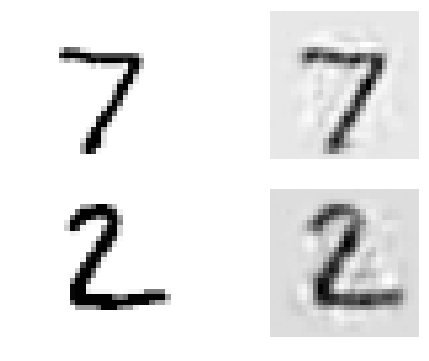

In [21]:
X_test_2 = X_test[:2]

with tf.Session() as sess:
    saver.restore(sess, "./model/sparse.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test_2})
    
fig = plt.figure(figsize=(8, 3 * 2))
for digit_index in range(2):
    plt.subplot(2, 2, digit_index * 2 + 1)
    plt.imshow(X_test_2[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.subplot(2, 2, digit_index * 2 + 2)
    plt.imshow(outputs_val[digit_index].reshape((28, 28)), 
               cmap="Greys", interpolation="nearest")
    plt.axis("off")

# Variational Autoencoder

In [29]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden1 = tf.layers.dense(X, n_hidden1, 
                          activation=tf.nn.elu, 
                          kernel_initializer=initializer)

hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                          activation=tf.nn.elu,
                          kernel_initializer=initializer)

hidden3_mean = tf.layers.dense(hidden2, n_hidden3,
                               kernel_initializer=initializer)
hidden3_sigma = tf.layers.dense(hidden2, n_hidden3,
                               kernel_initializer=initializer)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + noise * hidden3_sigma

hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                          activation=tf.nn.elu,
                          kernel_initializer=initializer)
hidden5 = tf.layers.dense(hidden4, n_hidden5, 
                          activation=tf.nn.elu,
                          kernel_initializer=initializer)

logits = tf.layers.dense(hidden5, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [30]:
eps = 1e-10
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print(epoch, "Train total loss:", loss_val, "Reconstruction loss:", reconstruction_loss_val, "Latent loss:", latent_loss_val)
        saver.save(sess, "./model/vae.ckpt")
        
    codings_rnd = np.random.normal(size=(60, n_hidden3))
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 30949.379 Reconstruction loss: 23805.617 Latent loss: 7143.7627
1 Train total loss: 27082.527 Reconstruction loss: 23379.3 Latent loss: 3703.2266
2 Train total loss: 34589.242 Reconstruction loss: 23831.488 Latent loss: 10757.755
3 Train total loss: 22327.432 Reconstruction loss: 19200.516 Latent loss: 3126.9165
4 Train total loss: 20446.12 Reconstruction loss: 17768.07 Latent loss: 2678.0483
5 Train total loss: 18157.52 Reconstruction loss: 15219.549 Latent loss: 2937.9702
6 Train total loss: 17248.375 Reconstruction loss: 14163.0 Latent loss: 3085.3755
7 Train total loss: 16925.525 Reconstruction loss: 13687.771 Latent loss: 3237.7546
8 Train total loss: 16457.05 Reconstruction loss: 13339.644 Latent loss: 3117.4067
9 Train total loss: 15668.079 Reconstruction loss: 12528.738 Latent loss: 3139.3408
10 Train total loss: 16426.691 Reconstruction loss: 13124.305 Latent loss: 3302.3872
11 Train total loss: 16213.62 Reconstruction loss: 12997.194 Latent loss: 3216.4255

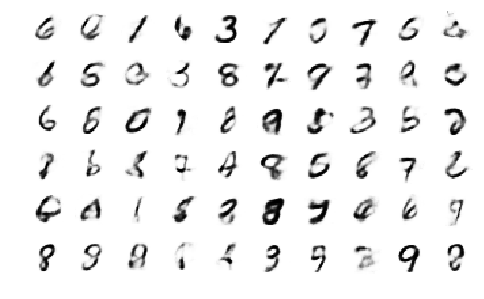

In [32]:
plt.figure(figsize=(8,50))
for iteration in range(60):
    plt.subplot(60, 10, iteration + 1)
    plt.imshow(outputs_val[iteration].reshape((28, 28)), 
               cmap="Greys", 
               interpolation="nearest")
    plt.axis("off")